In [1]:
from PIL import Image
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

In [2]:
from prompts import system_prompt

In [3]:
model_path = "../../downloads/Qwen2-VL-2B-Instruct"
# Load the model in half-precision on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path, torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Image
image = Image.open("../../downloads/raw_annotations/positive/bus-only_lane/images/20230527142135.043998_FrontCam02.jpeg")
image = image.resize((448*2, 448))
conversation = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_prompt}],
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            # {"type": "text", "text": "Describe this image."},
        ],
    }
]


# Preprocess the inputs
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

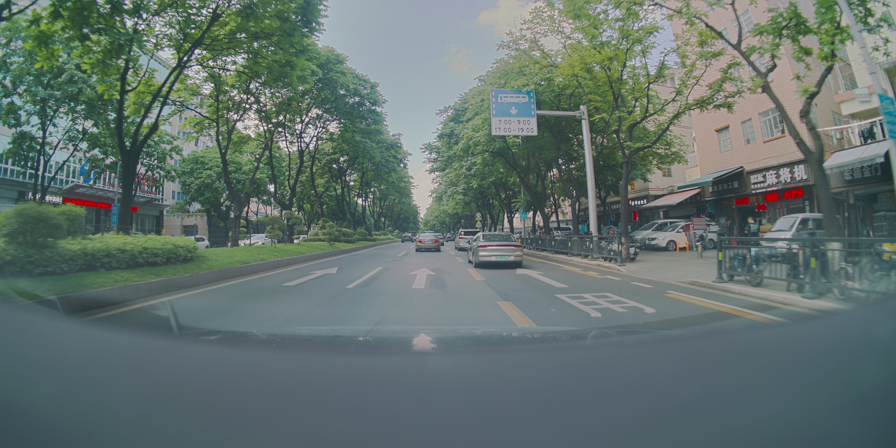

In [5]:
image

In [6]:
# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
print(output_text[0])


c:\App\miniconda\envs\default\Lib\site-packages\transformers\models\qwen2_vl\modeling_qwen2_vl.py:404: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = F.scaled_dot_product_attention(q, k, v, attention_mask, dropout_p=0.0)


1. Basic Information
```json
{
    "weather": "sunny",
    "time": "afternoon",
    "road_environment": "urban",
    "ego_lane_position": "middle"
}
```

2. Critical Objects
```json
{
    "object_name": "Bus Only Sign",
    "2d_bbox": [300, 400, 350, 450],
    "description": "Bus Only Sign is placed on the left side of the road."
}
```

3. Decision Analysis
The critical object "Bus Only Sign" indicates that the road is a bus lane. Since the ego car is in the middle lane, it should follow the bus lane rules and maintain a safe distance from the bus lane to avoid any potential conflicts.

4. Meta Action
The ego car should maintain a safe distance from the bus lane and follow the bus lane rules.
